# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.tensorboard import SummaryWriter

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
dataloader_train=torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.ToTensor()))


dataloader_no_train=torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.ToTensor()))

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [37]:
def get_mean_std(dataloader):

    mean=np.array([x[0].mean() for x in dataloader]).mean()
    std=np.array([x[0].std() for x in dataloader]).std()
    
    return mean,std

In [57]:
# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize(get_mean_std(dataloader_train)[0],
                                                                                   get_mean_std(dataloader_train)[1]
                                                                                   ,inplace=True) # normalize inputs
                                                          ])), 
                                           batch_size=64, 
                                           shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize(get_mean_std(dataloader_train)[0],
                                                                                   get_mean_std(dataloader_train)[1]
                                                                                   ,inplace=True) # normalize inputs
                                                          ])), 
                                           batch_size=64, 
                                           shuffle=True)

## Justify your preprocessing

I just used auto augment to reduce the likelyhood of overfitting 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [58]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        #print(images[i])
        #print(image.mode)
        plt.imshow(image.T.squeeze().T)
        plt.show()

6


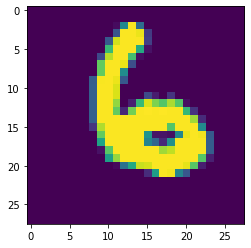

0


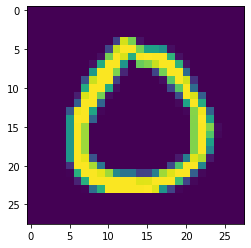

0


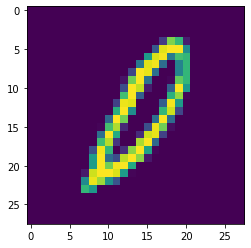

5


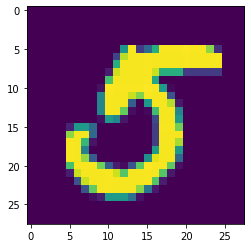

1


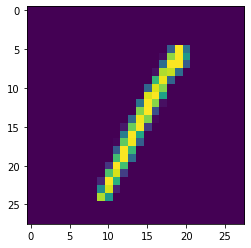

In [59]:
# Explore data
show5(test_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [60]:
# Define the class for your neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.dropout = nn.Dropout(0.2) 
        self.layer1 = nn.Linear(28*28,128)
        self.layer2 = nn.Linear(128,64)
        self.layer3 = nn.Linear(64,10)


    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = self.activation(self.layer1(x))
        x = self.dropout(x)
        x = self.activation(self.layer2(x))
        x = self.dropout(x)
       
        return self.layer3(x)



## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [65]:
def training(num_epochs,optimizer,criterion,net,train_loader,test_loader ):
    
    #check for GPU 
    if torch.cuda.is_available():
        # move tensor to CUDA
        device = torch.device("cuda")
        
    else:
        device = torch.device("cpu")

    net=net.to(device) 
    
    #tensorboard!!!
    #writer = SummaryWriter()
    
    #keep track of train and val loss:
    train_loss_history = list()
    val_loss_history = list()

    
    for epoch in range(num_epochs):
        
        net.train() # TRAIN MODE

        train_loss = 0.0
        train_correct = 0

        for i, data in enumerate(train_loader):

            # data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) 


            # Get the outputs of your model and compute your loss
            outputs = net(inputs)
            loss = criterion(outputs,labels)
            
            # Zero out the gradients of the optimizer
            optimizer.zero_grad()

            # Compute the loss gradient using the backward method and have the optimizer take a step
            loss.backward()
          
            
            # actually updates the weights, taking into account the learn rate and momentum:
            optimizer.step()

            # Compute the accuracy and print the accuracy and loss
            _, preds = torch.max(outputs.data, 1)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()

        print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
        train_loss_history.append(train_loss/len(train_loader))

        #writer.close()
        
        # Validation step 
        val_loss = 0.0
        val_correct = 0
        net.eval()
        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs).to(device)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
            

        print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
        val_loss_history.append(val_loss/len(test_loader))


    return net, train_loss_history, val_loss_history

net = Net()
optimizer = optim.Adam(net.parameters(), lr= 0.002)
criterion = nn.CrossEntropyLoss()


    
net, train_loss_history, val_loss_history = training(20,
                                                     optimizer,
                                                     criterion,
                                                     net,
                                                     train_loader,
                                                     test_loader)    
    

Epoch 1 training accuracy: 56.69% training loss: 0.37931
Epoch 1 validation accuracy: 60.79% validation loss: 0.15498
Epoch 2 training accuracy: 59.44% training loss: 0.24474
Epoch 2 validation accuracy: 61.04% validation loss: 0.13053
Epoch 3 training accuracy: 59.80% training loss: 0.22111
Epoch 3 validation accuracy: 61.43% validation loss: 0.11778
Epoch 4 training accuracy: 60.32% training loss: 0.19994
Epoch 4 validation accuracy: 61.48% validation loss: 0.12227
Epoch 5 training accuracy: 60.45% training loss: 0.19130
Epoch 5 validation accuracy: 61.83% validation loss: 0.10577
Epoch 6 training accuracy: 60.56% training loss: 0.18772
Epoch 6 validation accuracy: 61.68% validation loss: 0.11142
Epoch 7 training accuracy: 60.63% training loss: 0.18351
Epoch 7 validation accuracy: 61.75% validation loss: 0.10272
Epoch 8 training accuracy: 60.75% training loss: 0.17821
Epoch 8 validation accuracy: 61.70% validation loss: 0.11630
Epoch 9 training accuracy: 60.77% training loss: 0.17317

Plot the training loss (and validation loss/accuracy, if recorded).

In [46]:
#! tensorboard --logdir=/path/to/log/directory

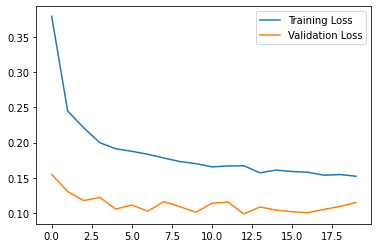

In [66]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
## YOUR CODE HERE ##

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [12]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
## YOUR CODE HERE ##